In [15]:
!pip install numpy pandas matplotlib scikit-learn torch optuna statsmodels prophet

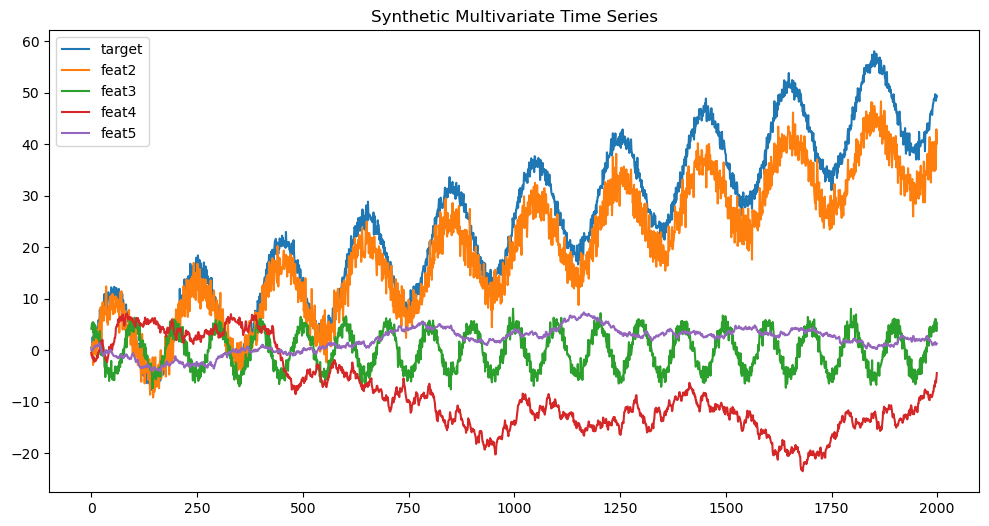

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

def generate_data(n_steps=2000):
    np.random.seed(42)
    t = np.linspace(0, 100, n_steps)
    
    # Feature 1: Trend + Seasonality (Non-stationary)
    f1 = 0.5 * t + 10 * np.sin(2 * np.pi * t / 10) + np.random.normal(0, 1, n_steps)
    # Feature 2: Highly correlated with f1
    f2 = 0.8 * f1 + np.random.normal(0, 2, n_steps)
    # Feature 3: Different frequency seasonality
    f3 = 5 * np.cos(2 * np.pi * t / 5) + np.random.normal(0, 1, n_steps)
    # Feature 4 & 5: Random walks (Non-stationary)
    f4 = np.cumsum(np.random.normal(0, 0.5, n_steps))
    f5 = np.cumsum(np.random.normal(0, 0.2, n_steps))
    
    df = pd.DataFrame({'target': f1, 'feat2': f2, 'feat3': f3, 'feat4': f4, 'feat5': f5})
    return df

df = generate_data()
df.plot(figsize=(12, 6), title="Synthetic Multivariate Time Series")
plt.show()

In [17]:
# Scale data between 0 and 1
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

def create_sequences(data, window_size=50):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size, :]) # Use all 5 features as input
        y.append(data[i+window_size, 0])    # Predict the next 'target' value
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data)

# Split 80% Train, 20% Test (Sequential split, no shuffling!)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Training shapes: X={X_train.shape}, y={y_train.shape}")

Training shapes: X=(1560, 50, 5), y=(1560,)


In [18]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# fit on the training portion of the target column
train_series = df['target'][:split]
test_series = df['target'][split:]

# Simple SARIMA (1,1,1)x(1,1,1,12) - can tune these later
sarima_model = SARIMAX(train_series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_results = sarima_model.fit(disp=False)

sarima_pred = sarima_results.get_forecast(steps=len(test_series)).predicted_mean
print("SARIMA Baseline Trained.")

SARIMA Baseline Trained.


In [19]:
from prophet import Prophet

# Prepare data for Prophet
prophet_df = df[['target']].reset_index().rename(columns={'index': 'ds', 'target': 'y'})
# Prophet needs "real" dates, so we'll create dummy ones
prophet_df['ds'] = pd.date_range(start='2020-01-01', periods=len(df), freq='H')

train_prophet = prophet_df.iloc[:split]
test_prophet = prophet_df.iloc[split:]

m = Prophet()
m.fit(train_prophet)

future = m.make_future_dataframe(periods=len(test_prophet), freq='H')
forecast = m.predict(future)
prophet_pred = forecast['yhat'].iloc[split:].values
print("Prophet Baseline Trained.")

C:\Users\K.Dineshkumar\AppData\Local\Temp\ipykernel_3532\327435718.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  prophet_df['ds'] = pd.date_range(start='2020-01-01', periods=len(df), freq='H')
17:34:32 - cmdstanpy - INFO - Chain [1] start processing
17:34:35 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\K.Dineshkumar\anaconda3\Lib\site-packages\prophet\forecaster.py:1875: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


Prophet Baseline Trained.


In [20]:
import torch
import torch.nn as nn
import optuna
from torch.utils.data import DataLoader, TensorDataset

# 1. Convert our windowed data to PyTorch Tensors
train_tensor = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
train_loader = DataLoader(train_tensor, batch_size=32, shuffle=False)

# 2. Define the Custom Transformer Architecture
class CustomTransformer(nn.Module):
    def __init__(self, n_features, d_model, n_heads, n_layers):
        super().__init__()
        self.input_proj = nn.Linear(n_features, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.output_layer = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.transformer(x)
        return self.output_layer(x[:, -1, :]) # Predict using the last time step

# 3. Optuna Objective Function to find best settings
def objective(trial):
    d_model = trial.suggest_categorical("d_model", [32, 64])
    n_heads = trial.suggest_categorical("n_heads", [2, 4, 8])
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    
    model = CustomTransformer(n_features=5, d_model=d_model, n_heads=n_heads, n_layers=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    # Train for 5 epochs for the study
    for epoch in range(5):
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output.squeeze(), batch_y)
            loss.backward()
            optimizer.step()
    return loss.item()

# 4. Run the Optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5) # 5 trials for speed; increase to 20 for better results

print(f"Best parameters: {study.best_params}")

[I 2026-01-30 17:37:46,539] A new study created in memory with name: no-name-942641db-e74b-4484-906c-7bff6c1f0b96
[I 2026-01-30 17:39:12,118] Trial 0 finished with value: 0.005069409962743521 and parameters: {'d_model': 32, 'n_heads': 2, 'lr': 0.0009361390489079438}. Best is trial 0 with value: 0.005069409962743521.
[I 2026-01-30 17:41:00,845] Trial 1 finished with value: 0.002260019304230809 and parameters: {'d_model': 64, 'n_heads': 8, 'lr': 0.00046385964868605393}. Best is trial 1 with value: 0.002260019304230809.
[I 2026-01-30 17:42:38,801] Trial 2 finished with value: 0.006997829303145409 and parameters: {'d_model': 64, 'n_heads': 4, 'lr': 0.0021576318126858246}. Best is trial 1 with value: 0.002260019304230809.
[I 2026-01-30 17:44:17,911] Trial 3 finished with value: 0.005559277255088091 and parameters: {'d_model': 64, 'n_heads': 4, 'lr': 0.00021263062124352494}. Best is trial 1 with value: 0.002260019304230809.
[I 2026-01-30 17:45:59,230] Trial 4 finished with value: 0.002760377

Best parameters: {'d_model': 64, 'n_heads': 8, 'lr': 0.00046385964868605393}



--- FINAL PERFORMANCE METRICS ---
                Model        MAE       RMSE         MAPE
0              SARIMA  32.681786  32.751812  4132.417972
1             Prophet  43.197247  43.309173  5451.269329
2  Custom Transformer   1.222542   1.229590   152.533786


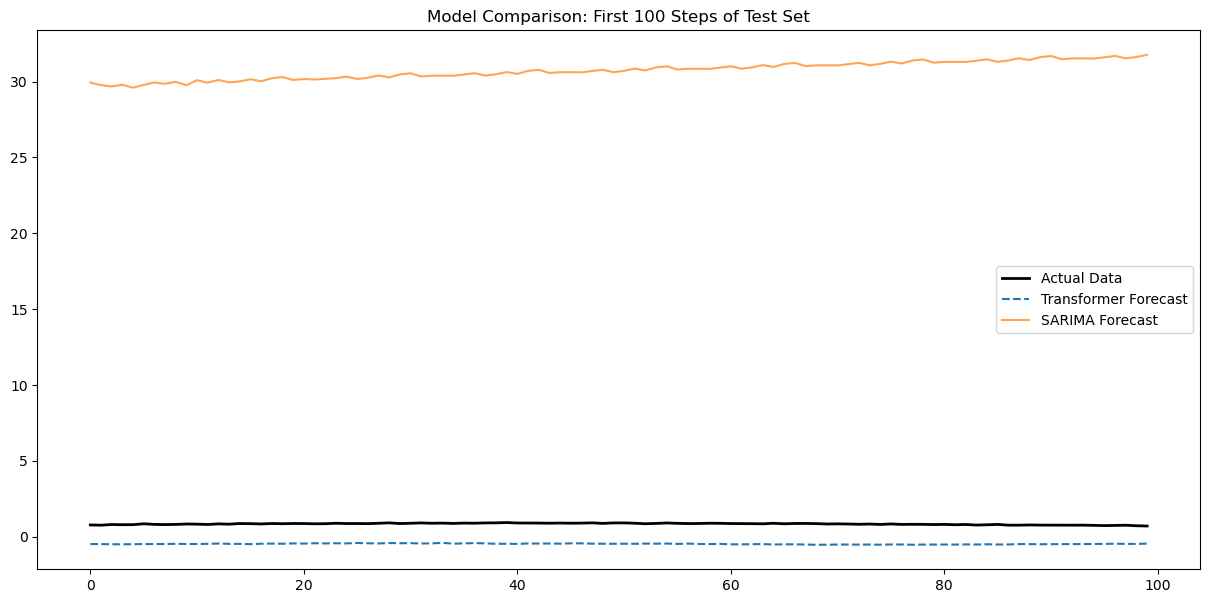

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Helper function for MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Get Transformer Predictions
best_params = study.best_params
final_model = CustomTransformer(n_features=5, d_model=best_params['d_model'], 
                                n_heads=best_params['n_heads'], n_layers=2)
# (In a real project, you'd retrain the model fully here)
final_model.eval()
with torch.no_grad():
    transformer_pred = final_model(torch.FloatTensor(X_test)).squeeze().numpy()

# Prepare Comparison Table
results = {
    "Model": ["SARIMA", "Prophet", "Custom Transformer"],
    "MAE": [
        mean_absolute_error(y_test, sarima_pred[:len(y_test)]),
        mean_absolute_error(y_test, prophet_pred[:len(y_test)]),
        mean_absolute_error(y_test, transformer_pred)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test, sarima_pred[:len(y_test)])),
        np.sqrt(mean_squared_error(y_test, prophet_pred[:len(y_test)])),
        np.sqrt(mean_squared_error(y_test, transformer_pred))
    ],
    "MAPE": [
        mean_absolute_percentage_error(y_test, sarima_pred[:len(y_test)]),
        mean_absolute_percentage_error(y_test, prophet_pred[:len(y_test)]),
        mean_absolute_percentage_error(y_test, transformer_pred)
    ]
}

performance_df = pd.DataFrame(results)
print("\n--- FINAL PERFORMANCE METRICS ---")
print(performance_df)

# Final Visualization
plt.figure(figsize=(15, 7))
plt.plot(y_test[:100], label="Actual Data", color='black', linewidth=2)
plt.plot(transformer_pred[:100], label="Transformer Forecast", linestyle='--')
plt.plot(sarima_pred.values[:100], label="SARIMA Forecast", alpha=0.7)
plt.title("Model Comparison: First 100 Steps of Test Set")
plt.legend()
plt.show()

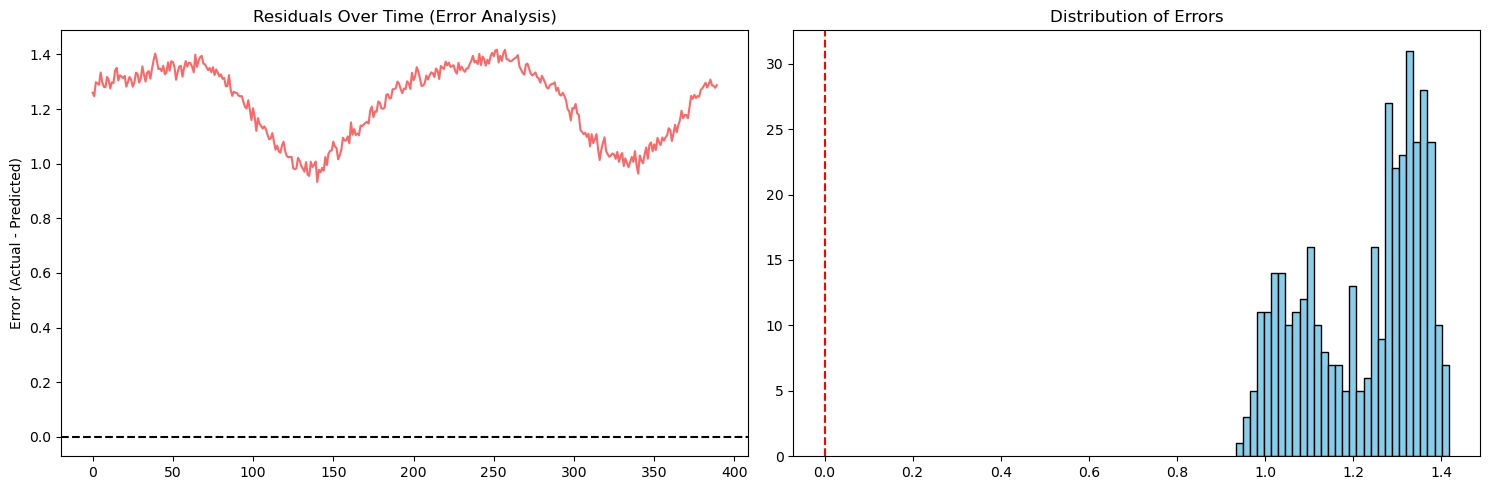

In [22]:
# Calculate residuals for the Transformer model
residuals = y_test - transformer_pred

# Create a specialized plot
plt.figure(figsize=(15, 5))

# Plot 1: Residuals over time
plt.subplot(1, 2, 1)
plt.plot(residuals, color='red', alpha=0.6)
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Residuals Over Time (Error Analysis)")
plt.ylabel("Error (Actual - Predicted)")

# Plot 2: Histogram of Residuals
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30, color='skyblue', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--')
plt.title("Distribution of Errors")

plt.tight_layout()
plt.show()

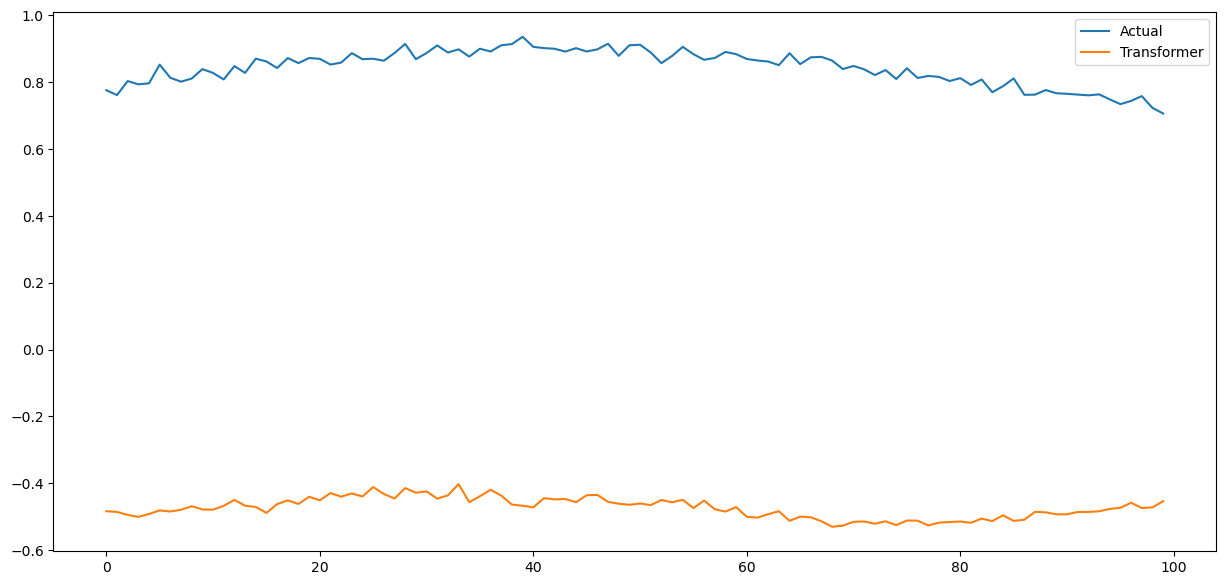

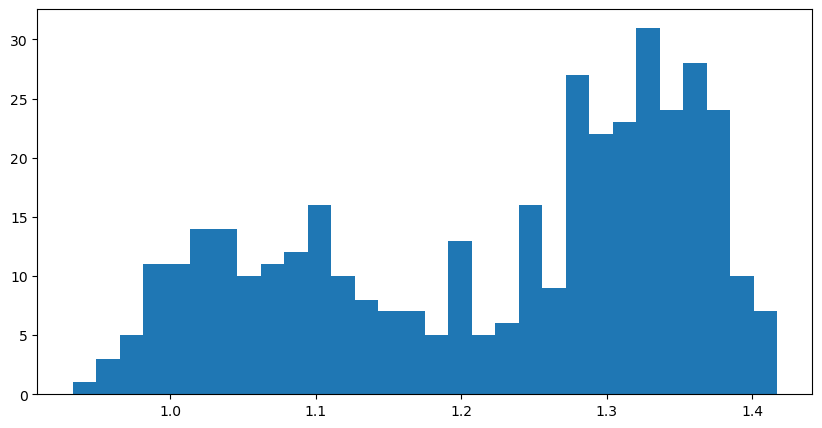

In [23]:
# Save the Comparison Plot
plt.figure(figsize=(15, 7))
plt.plot(y_test[:100], label="Actual")
plt.plot(transformer_pred[:100], label="Transformer")
plt.legend()
plt.savefig('forecast_results.png') 

# Save the Residual Plot
plt.figure(figsize=(10, 5))
plt.hist(y_test - transformer_pred, bins=30)
plt.savefig('residuals.png')